### Setup and imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys, os, numpy as np

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')

assert os.path.isdir("pcmf_p3ca"), "pcmf_p3ca folder not found under PARENT"

from pcmf_p3ca import Loader1D, Loader2D, PCMF, LLPCMF, P3CA, ConsensusPCMF


### Load data

In [2]:
# Load synthetic 1D data

num_vars = 300 # number of varibles p
density = 0.5 # redundancy delta
cluster_sizes = [50,50] # cluster sizes N_1 and N_2
cluster_means = [-.25,.25] # cluster mean values, 'non-overlapping'data
#cluster_means = [-0.05,0.005] # cluster mean values, 'overlapping' data
sigma=0.075 # noise coefficient
X_1, labels_X1 = Loader1D.generate_two_cluster_data(m=cluster_sizes, means=cluster_means, n_X=num_vars, 
                                               density=density, sigma=sigma, seeds=[14,15],
                                               scale_data=True, intercept=True)

# Load Penguins data
X_p, Y_p, labels_p, labels_p_names, names_p = Loader2D.load_penguins_data(scale_data=True, intercept=True)


### Run models


#### Run Pathwise Clustered Matrix Factorization (PCMF)


initializing PCMF model
running PCMF model


Lambda path: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [01:03<00:00,  2.51it/s]


Estimating clusters along PCMF path.
Best Penalty IDX: 11, ARI: 1.0, NMI: 1.0
Xhat (100, 301) G (4950, 301) S (100, 1) U (1,) V (1, 301)


array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0], dtype=int32)

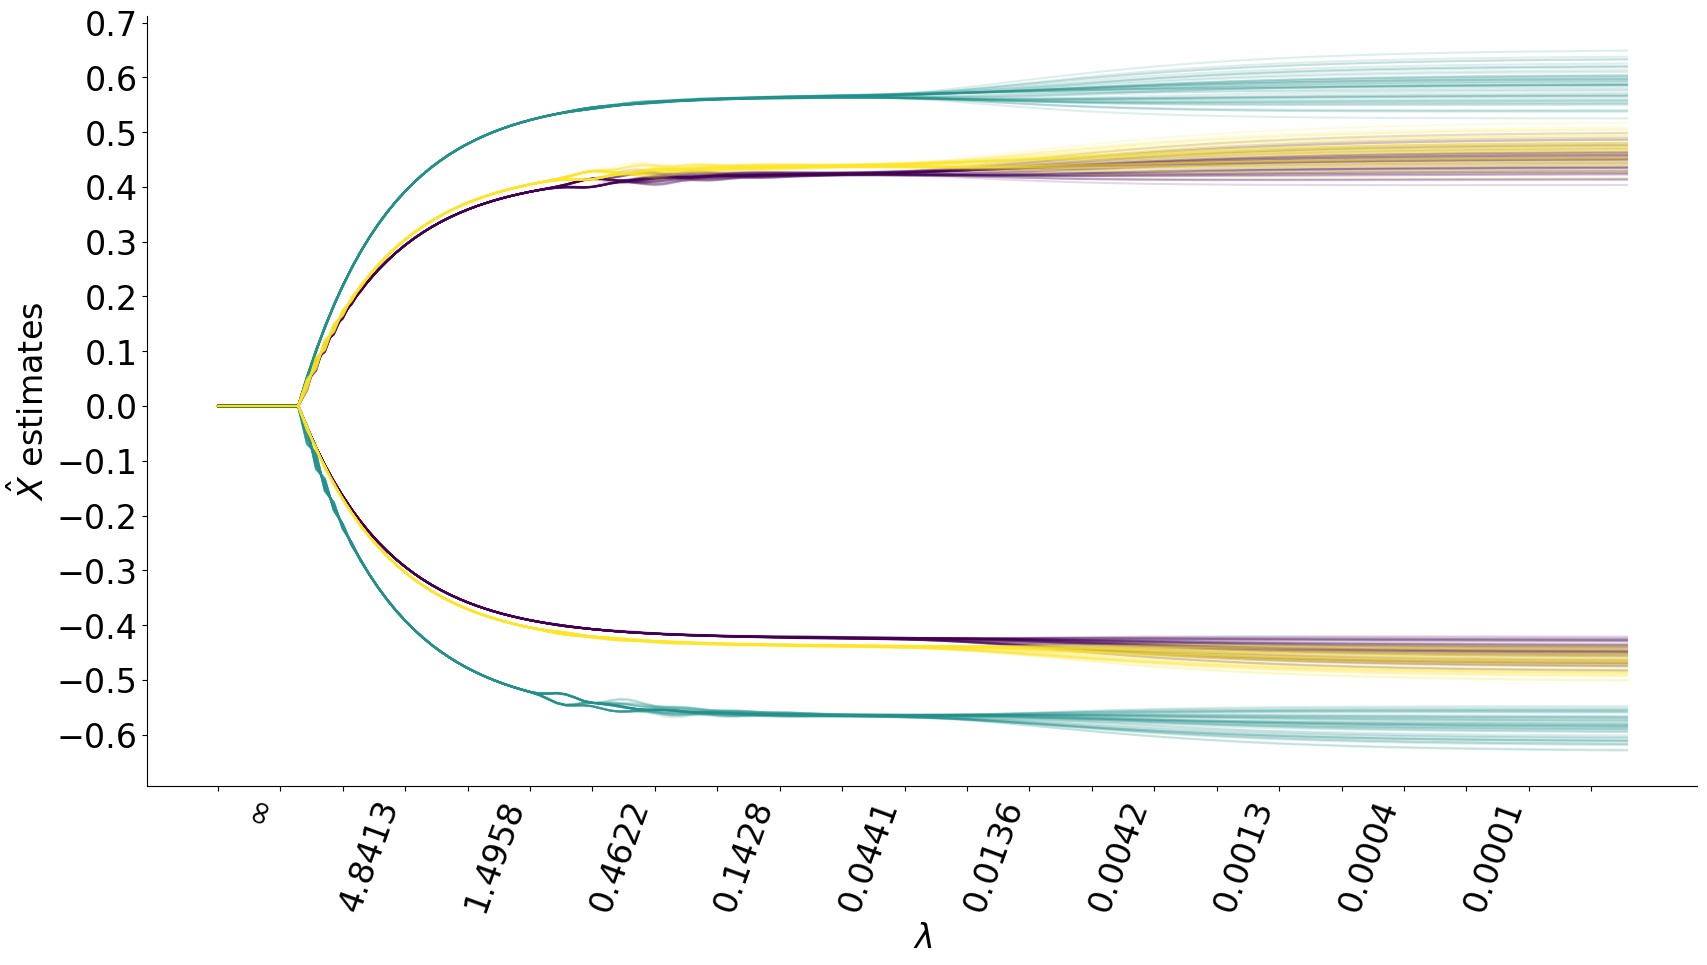

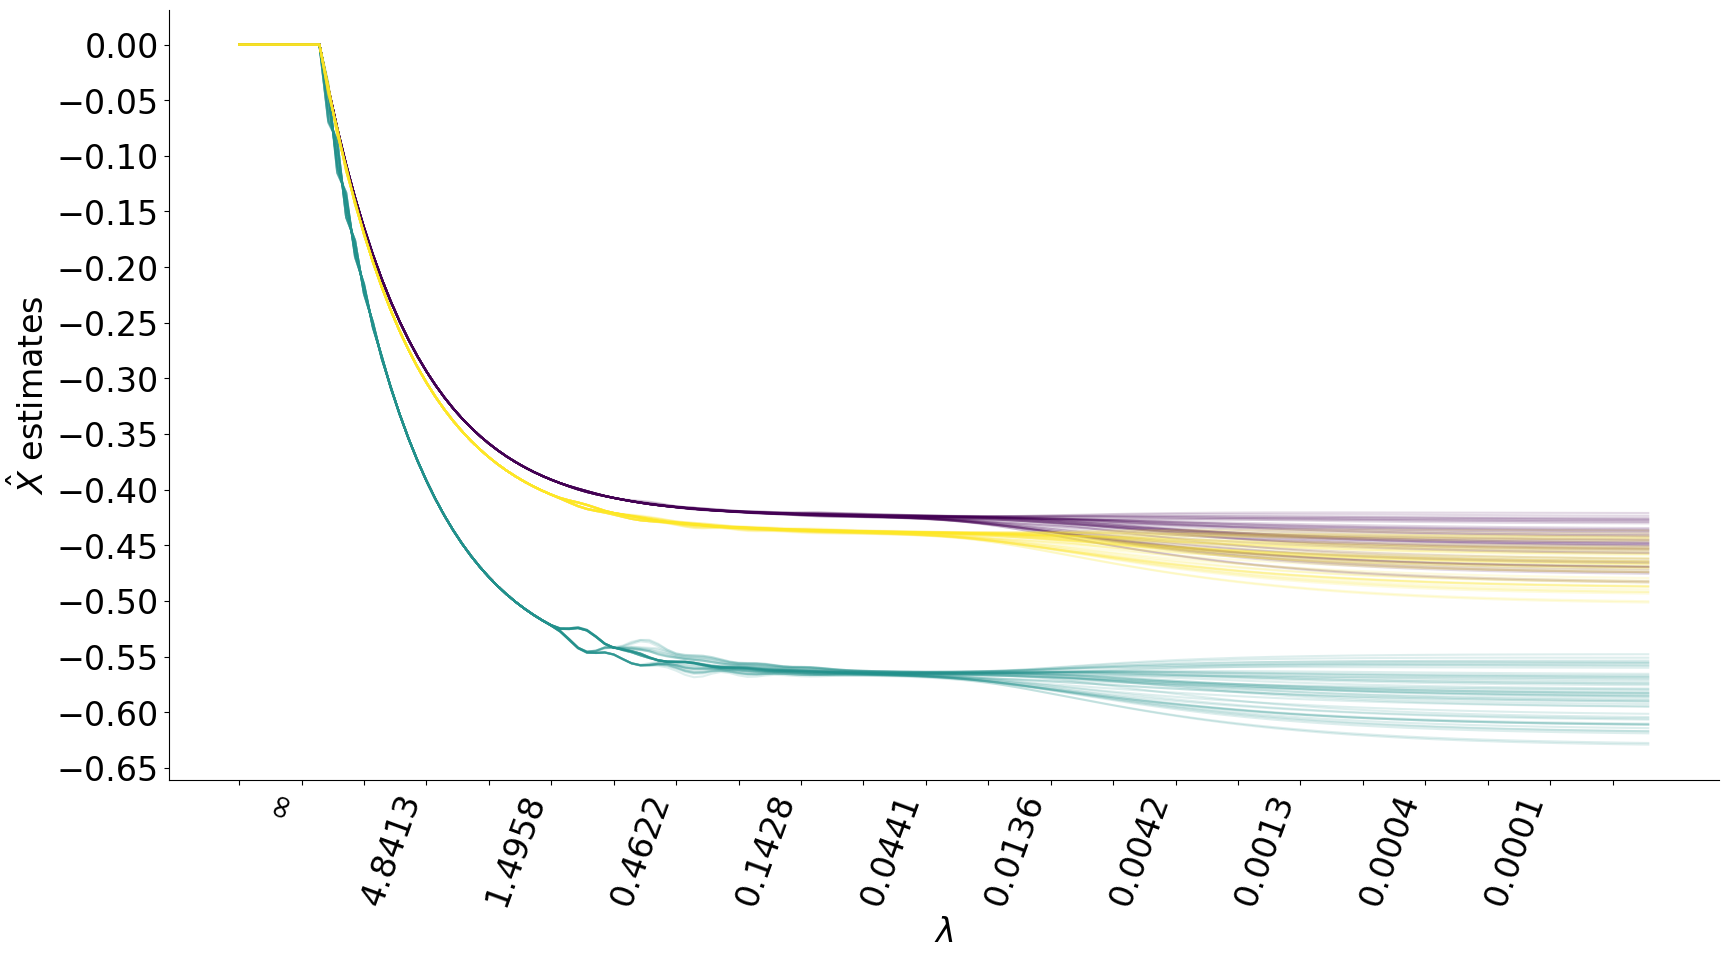

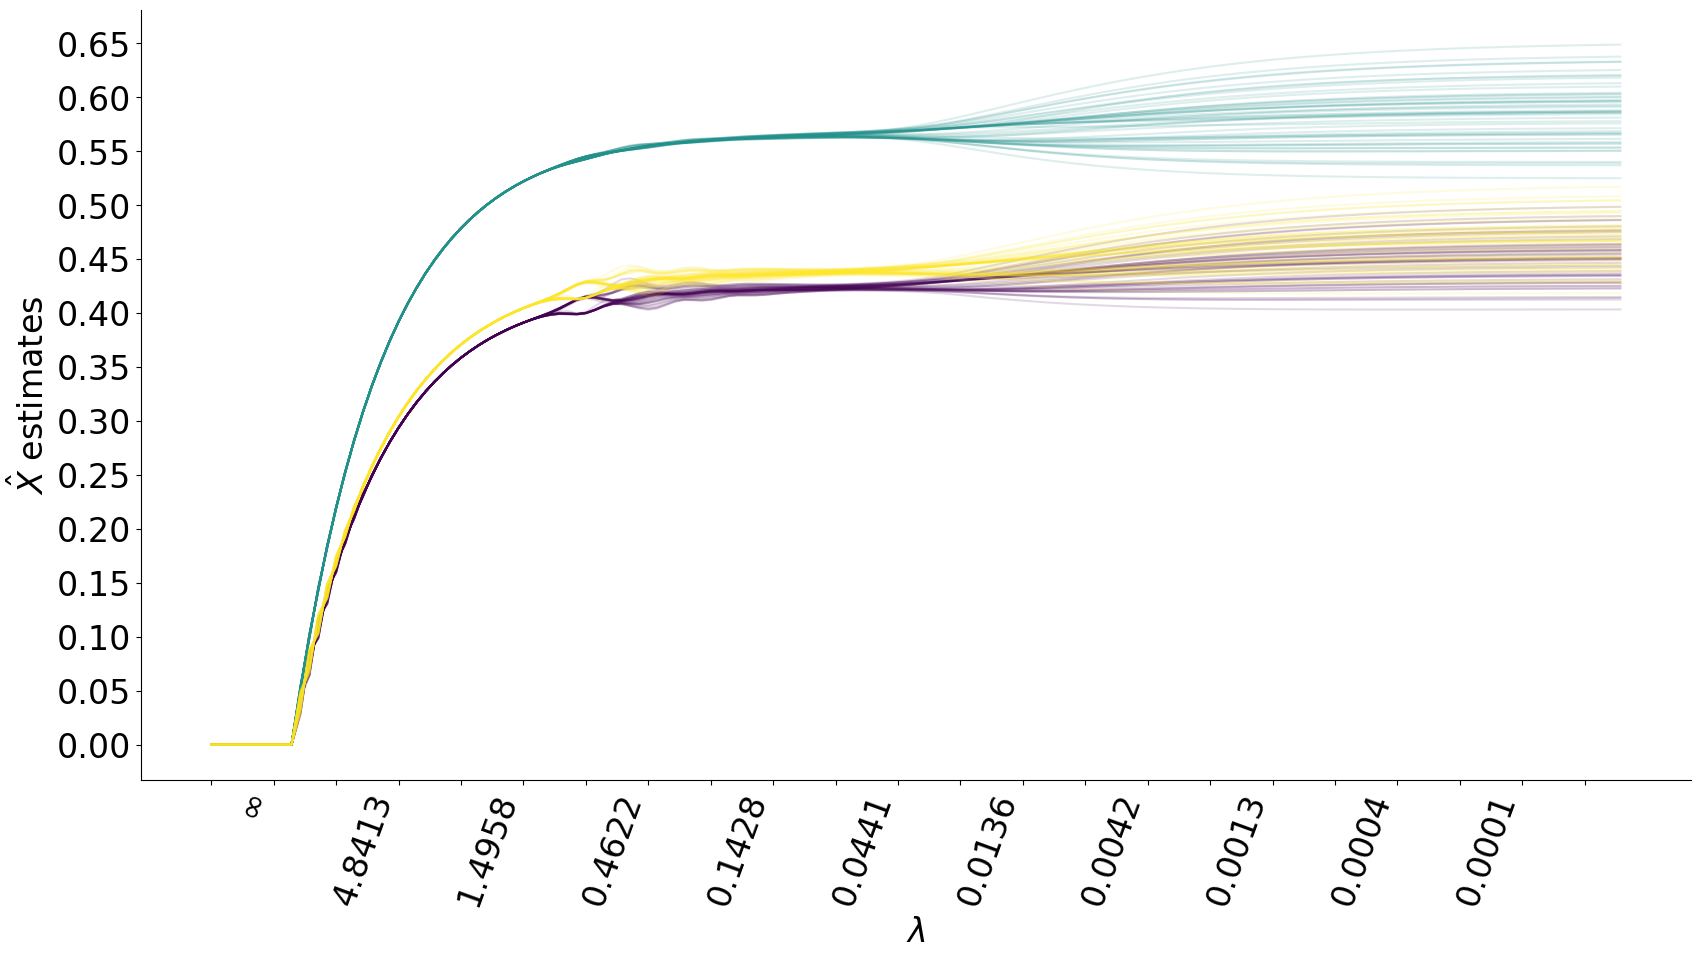

In [3]:
# Set a decreasing penalty list, forcing a single cluster solution by starting with \lambda = np.inf
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-10,2.5,150))[::-1]),axis=0)

model_PCMF = PCMF(penalty_list=penalty_list, admm_iters=10, problem_rank=1, rho=1, gauss_coef=2.0, neighbors=25, 
                 prox_method="numba", # numba, python, c
                 progress_mode="bar"
                 )
model_PCMF.fit(X_1, true_clusters=labels_X1)
model_PCMF.select(trim_init_lambdas=10);
model_PCMF.plot_path()

# Return model parameters and cluster labels for best fit
Xhat, G, S, U, V = model_PCMF.return_fit(lam='best')
print('Xhat', Xhat.shape, 'G', G.shape, 'S',S.shape, 'U', U.shape, 'V',V.shape)
model_PCMF.return_labels(lam='best')


#### Run Consensus Pathwise Clustered Matrix Factorization (PCMF)


Lambda path: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:41<00:00,  3.87it/s]


Estimating clusters along Consensus PCMF path.
Best Penalty IDX: 21, ARI: 1.0, NMI: 1.0
Xhat (100, 301) G (2450, 301) S (100, 1) U (1,) V (1, 301)


array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1], dtype=int32)

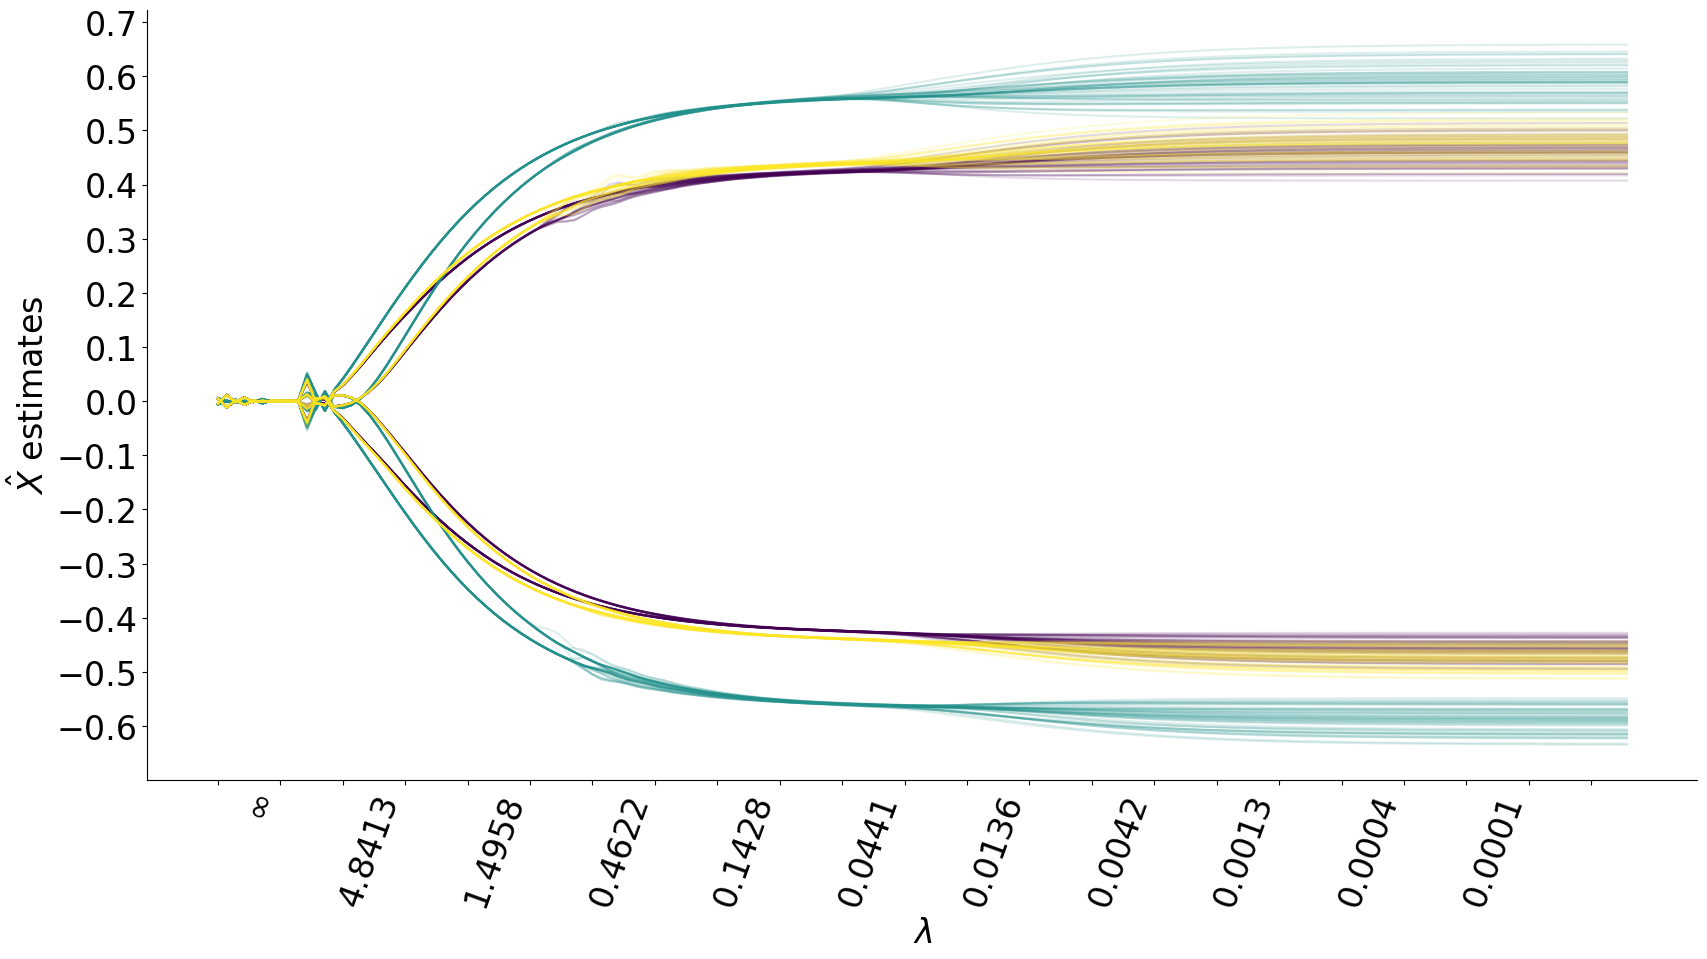

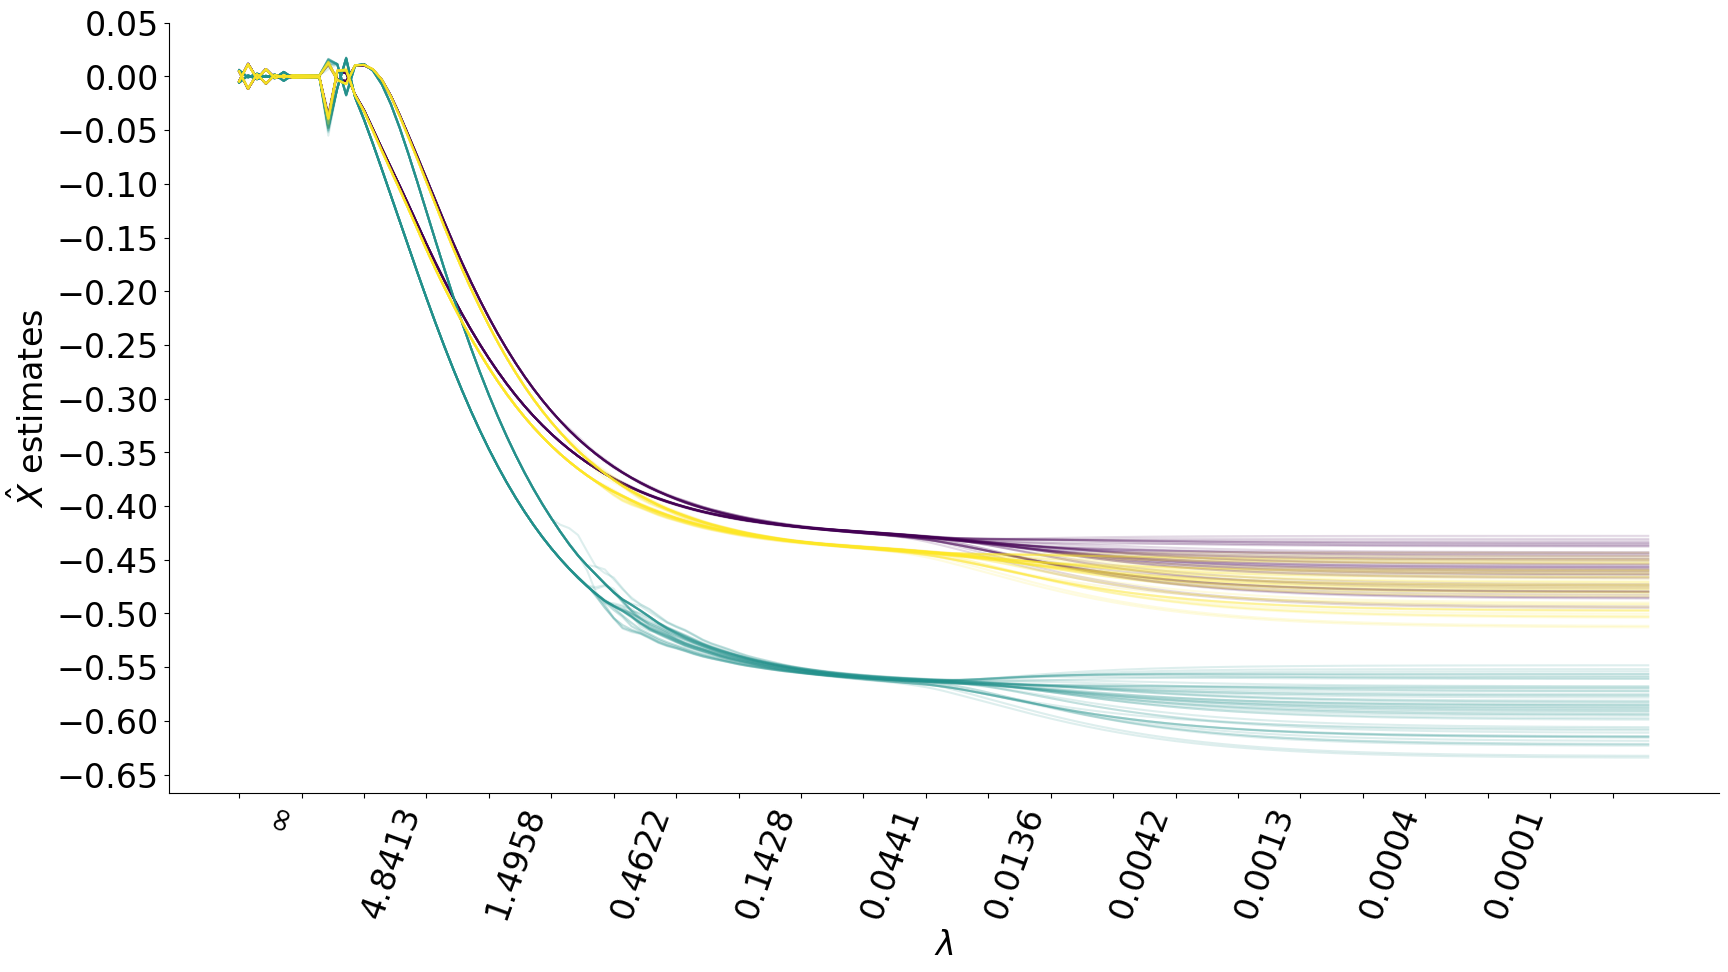

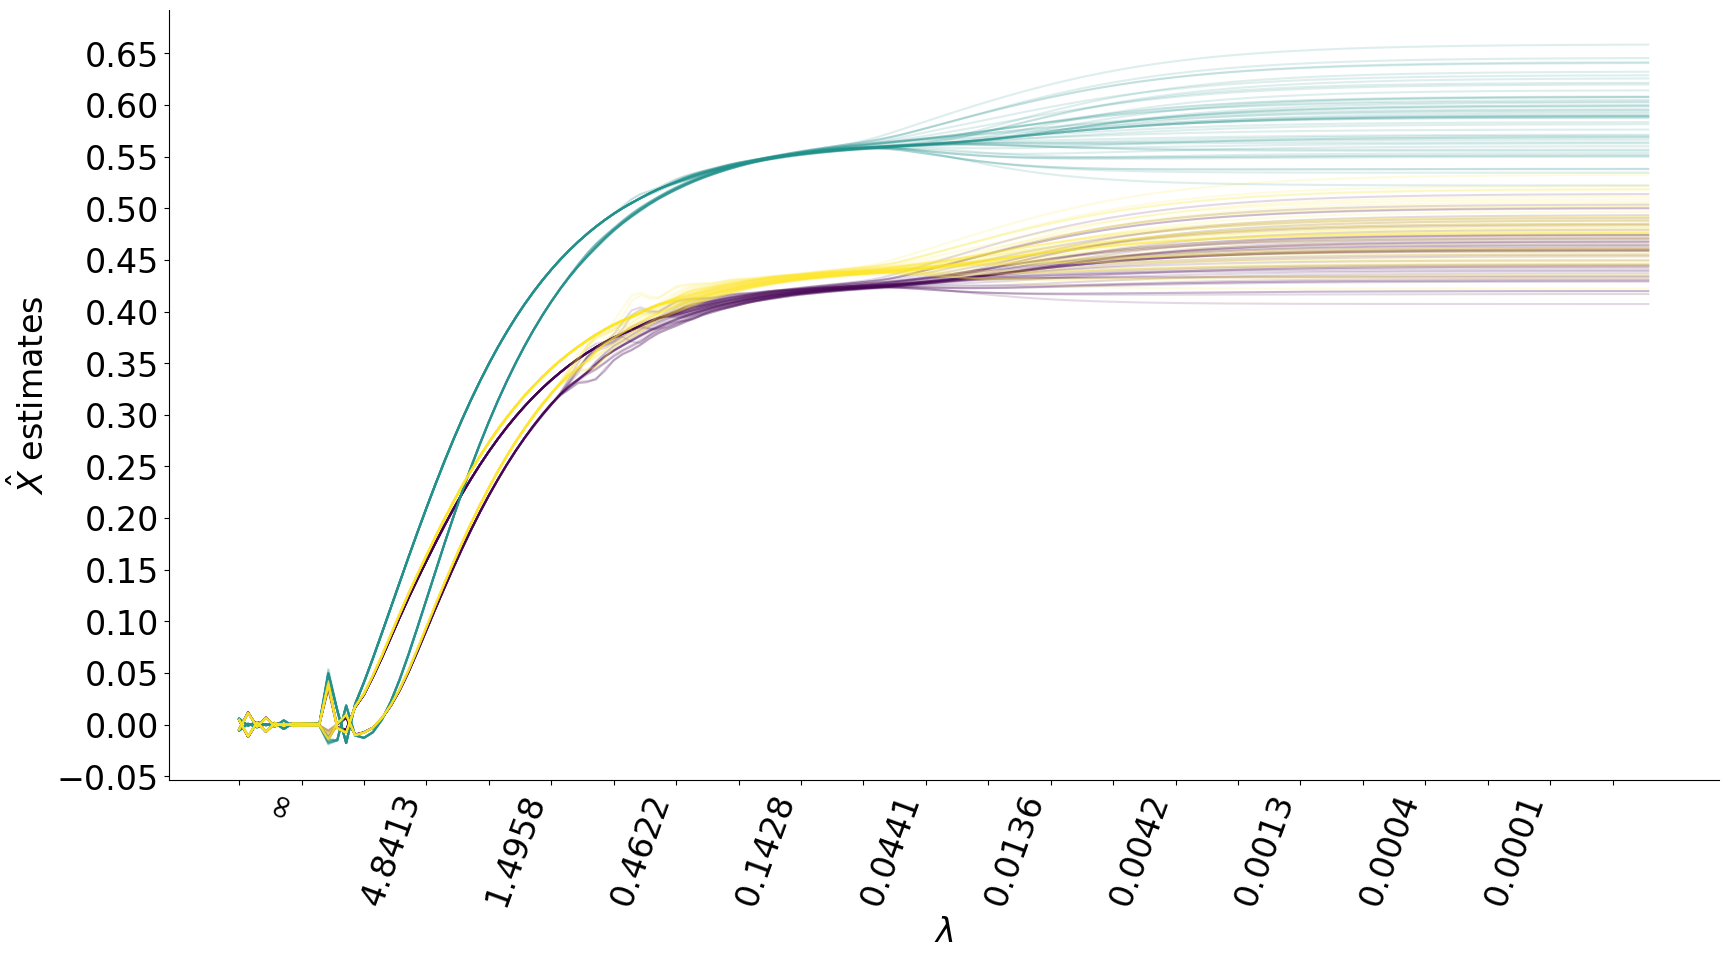

In [4]:
# Set a decreasing penalty list, forcing a single cluster solution by starting with \lambda = np.inf
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-10,2.5,150))[::-1]),axis=0)

model_consensusPCMF =   ConsensusPCMF(
                        penalty_list=penalty_list,
                        admm_iters=10,
                        problem_rank=1,
                        rho=1,
                        gauss_coef=2.0,
                        split_size=50,
                        neighbors=25,
                        prox_method="numba", # numba, python, c
                        progress_mode="bar",
                    )
model_consensusPCMF.fit(X_1, labels_X1);
model_consensusPCMF.select(trim_init_lambdas=10);
model_consensusPCMF.plot_path()

# Return model parameters and cluster labels for best fit
Xhat, G, S, U, V = model_consensusPCMF.return_fit(lam='best')
print('Xhat', Xhat.shape, 'G', G.shape, 'S',S.shape, 'U', U.shape, 'V',V.shape)
model_consensusPCMF.return_labels(lam='best')


#### Run Locally Linear Pathwise Clustered Matrix Factorization (PCMF)

Lambda path: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [04:06<00:00,  1.54s/it]


Estimating clusters along LL-PCMF path.
Best Penalty IDX: 10, ARI: 1.0, NMI: 1.0
u (100, 1) s (100,) V (100, 301)


array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0], dtype=int32)

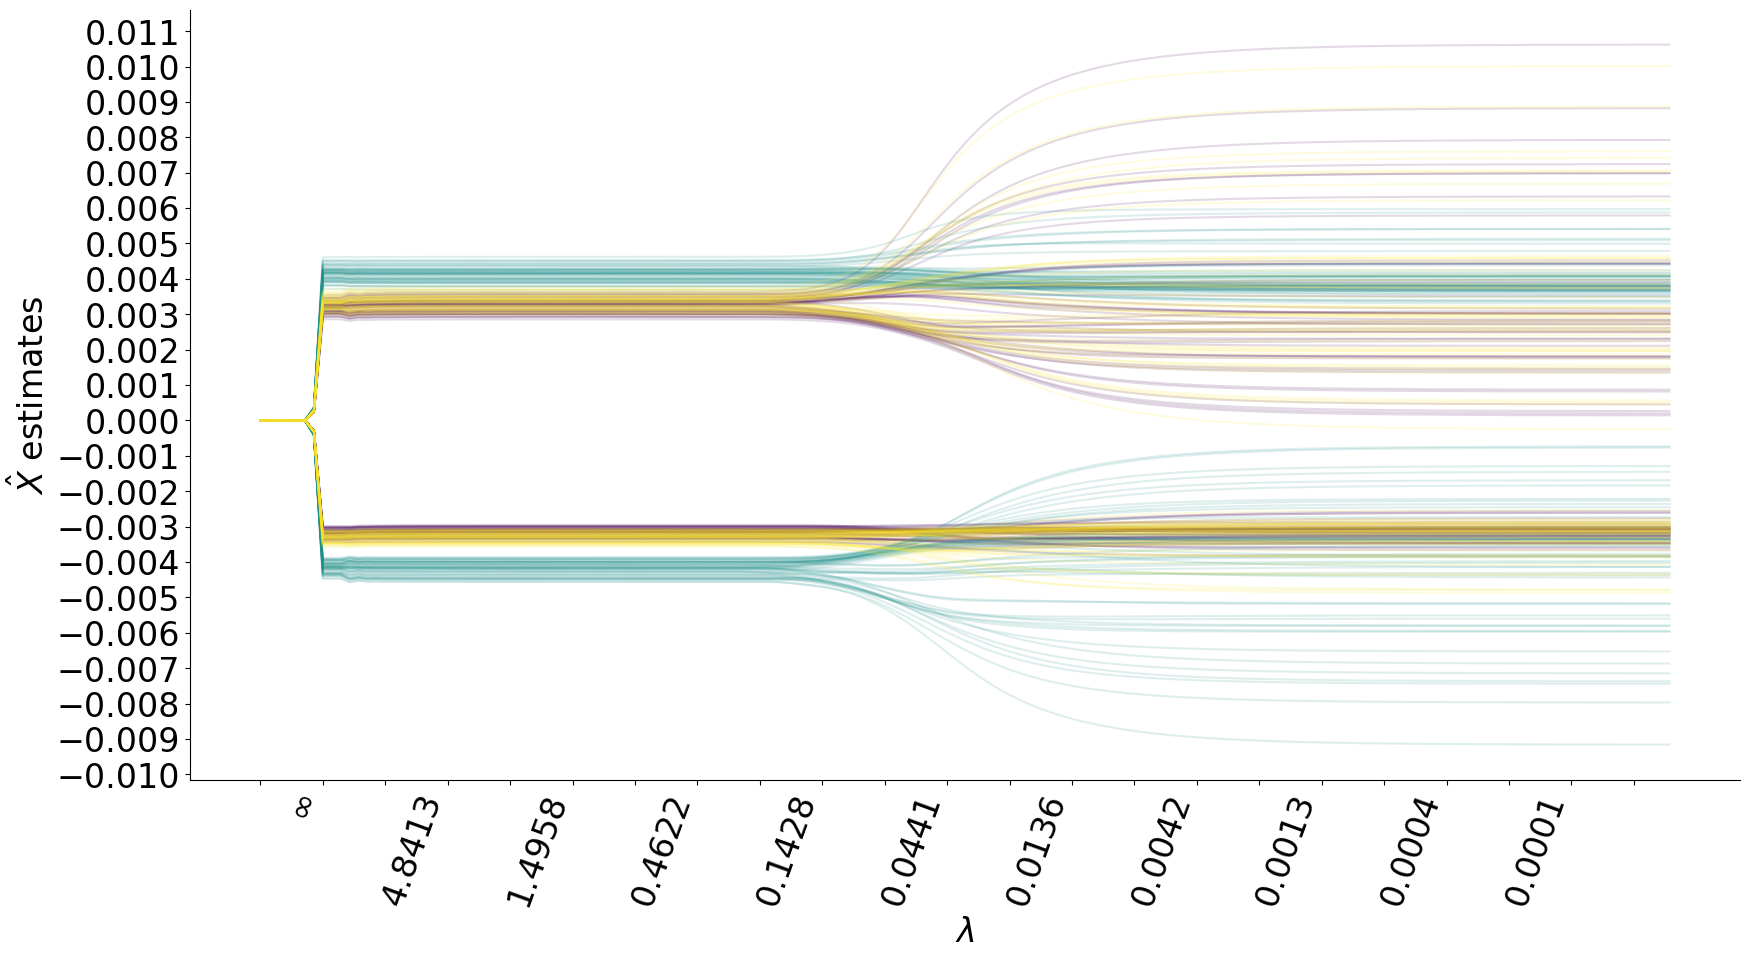

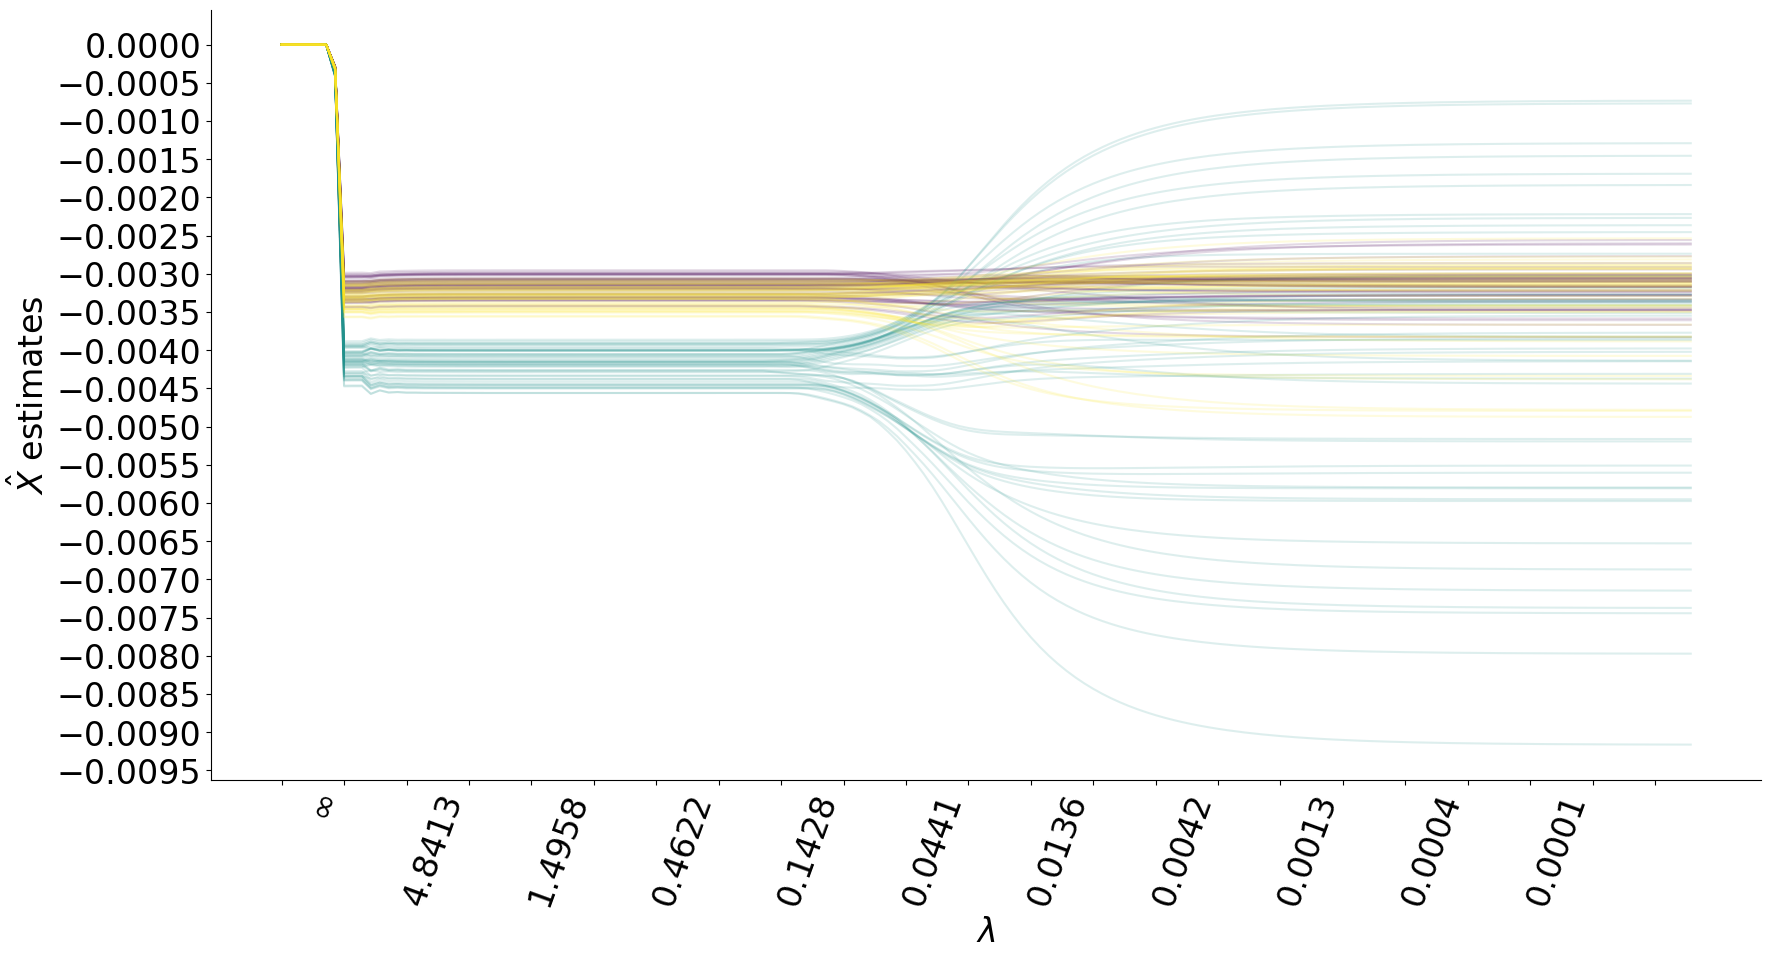

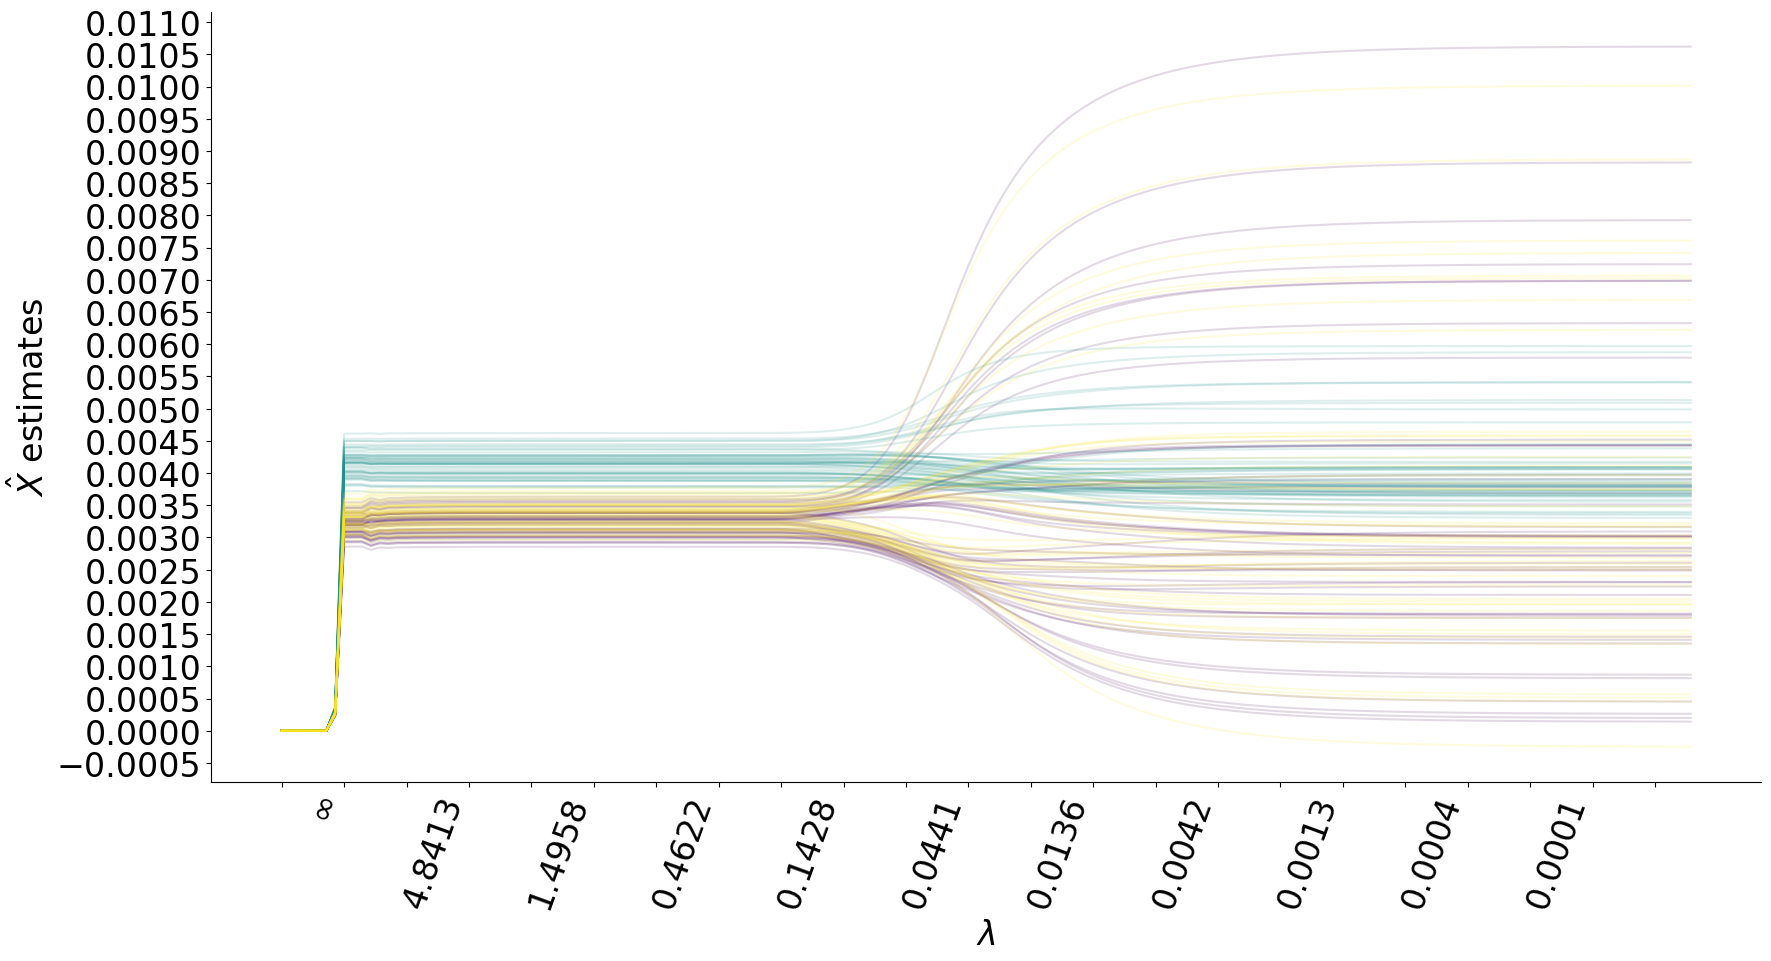

In [5]:
# Set a decreasing penalty list, forcing a single cluster solution by starting with \lambda = np.inf
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-10,2.5,150))[::-1]),axis=0)

model_LLPCMF = LLPCMF(penalty_list=penalty_list, admm_iters=10, rho=1.5, gauss_coef=2.0, neighbors=25, 
                 prox_method="c", # numba, python, c
                 progress_mode="bar"
                 )
model_LLPCMF.fit(X_1, labels_X1);
model_LLPCMF.select(trim_init_lambdas=10)
model_LLPCMF.plot_path()

# Return model parameters and cluster labels for best fit
u, s, V = model_LLPCMF.return_fit(lam='best')
print('u', u.shape, 's', s.shape, 'V',V.shape)
model_LLPCMF.return_labels(lam='best')


#### Run Pathwise Clustered Canonical Correlation Analysis (P3CA)


Lambda path: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:56<00:00,  1.29it/s]


Estimating clusters along P3CA path.
Best Penalty IDX: 69, ARI: 0.923216821800147, NMI: 0.8822926897685065
U (342, 3) V (342, 3)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2,

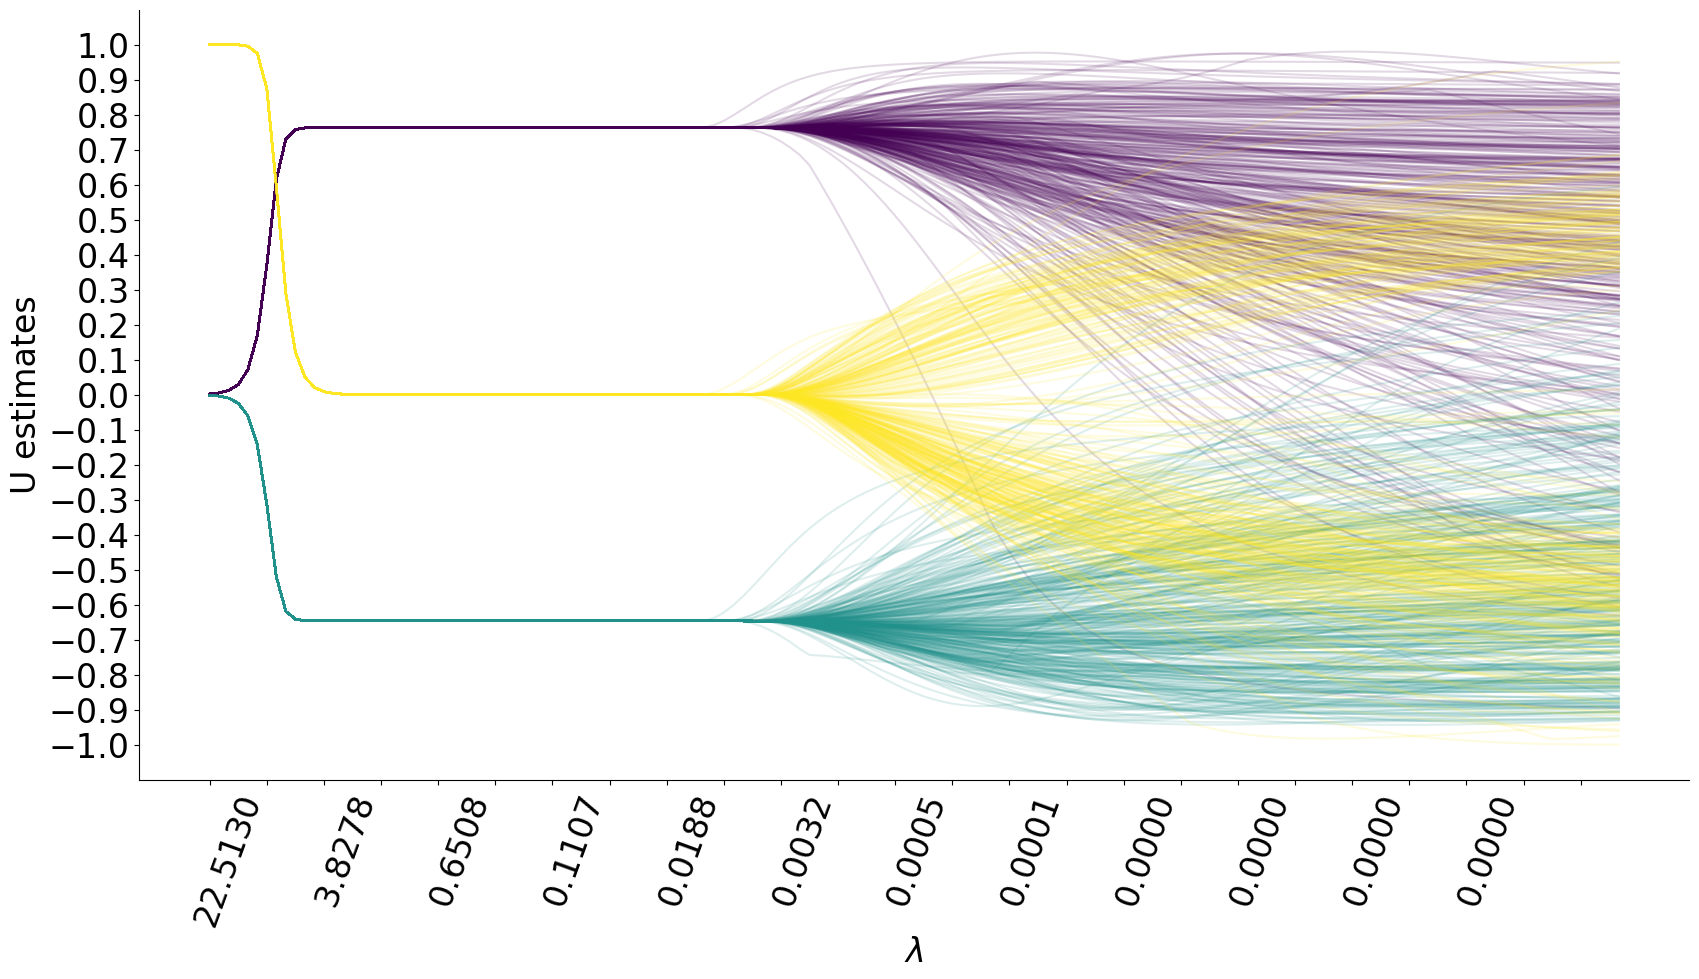

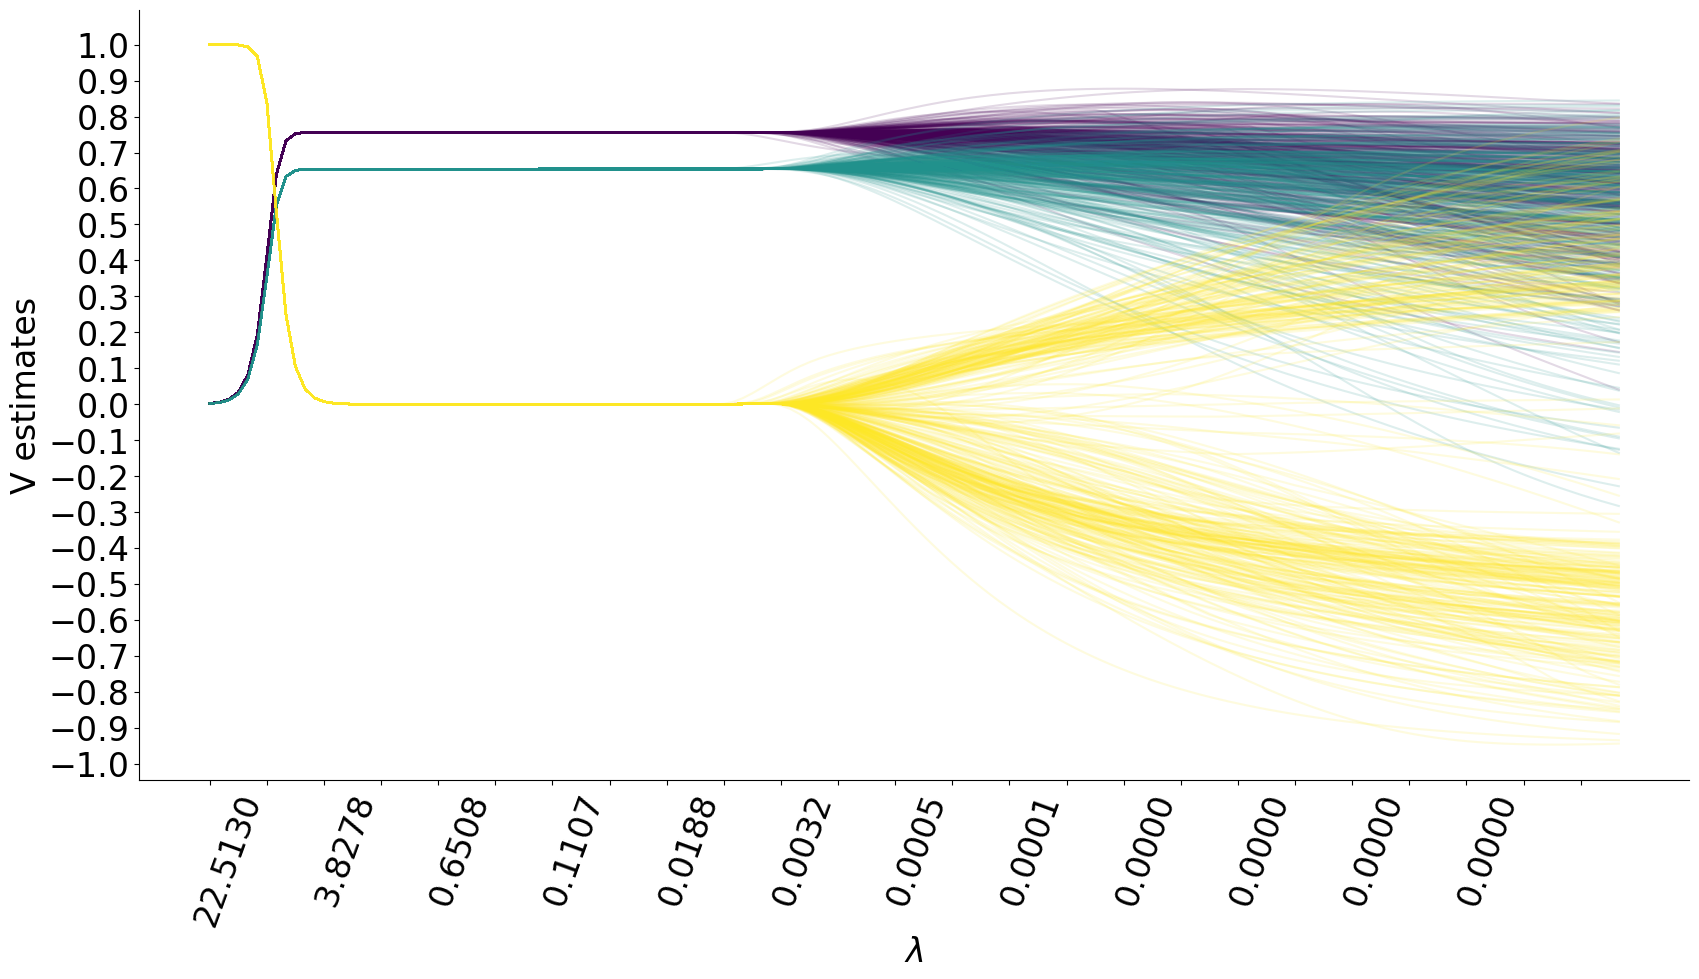

In [6]:
# Set decreasing penalty list
penalty_list = np.exp(np.linspace(-18,4,150))[::-1]

model_P3CA = P3CA(penalty_list=penalty_list, admm_iters=3, cca_iters=3, rho=1.5, gauss_coef=2.0, neighbors=None, 
                 prox_method="numba", # numba, python, c
                 progress_mode="bar"
                 )
model_P3CA.fit(X_p, Y_p, true_clusters=labels_p);
model_P3CA.select(trim_init_lambdas=10);
model_P3CA.plot_path()


# Return model parameters and cluster labels for best fit
U, V = model_P3CA.return_fit(lam='best')
print('U', U.shape, 'V',V.shape)
model_P3CA.return_labels(lam='best')


### Cite:

**Amanda M. Buch, Conor Liston, Logan Grosenick.** *Simple and scalable algorithms for cluster‑aware precision medicine.* AISTATS 2024 (PMLR 238:136–144).  
Paper: https://proceedings.mlr.press/v238/buch24a.html
